In [ ]:
import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import urllib.request
import os
from progressbar import ProgressBar
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Use your own project_path
project_path = '/content/drive/My Drive/CD-on-Steam-Games/'
# game_data = pd.read_csv(project_path+'data/total_data.csv')
game_data = pd.read_csv(project_path+'data/total_data_processed.csv')
game_data.set_index('AppID', inplace=True)
# game_data = game_data.sort_values(by='Rating',ascending=False)

In [ ]:
game_data.head()

,Name,Positive,Negative,Rating,Current,24h Peak,All-Time Peak
AppID,,,,,,,
105600,Terraria,"289,493","8,213",96.18%,"21,860","31,505","159,175"
10,Counter-Strike,"133,134","3,541",96.06%,"6,299","14,655","319,586"
550,Left 4 Dead 2,"273,711","8,878",95.79%,"10,171","17,645","162,399"
447530,VA-11 Hall-A: Cyberpunk Bartender Action,"14,409",323,95.15%,292,565,"1,574"
220,Half-Life 2,"72,913","2,488",95.11%,790,"1,502","12,953"


In [ ]:
len(game_data)

271

In [ ]:
import glob
all_files = glob.glob('./*csv')

li = [pd.read_csv(filename, index_col=None, header=0) for filename in all_files]

game_sift = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
game_sift.set_index('AppID', inplace=True)

In [ ]:
# game_sift = pd.read_csv(project_path+'game_final2.csv')
# game_sift.set_index('AppID', inplace=True)
# del game_sift['Unnamed: 0']

In [ ]:
len(game_sift)

NameError: ignored

In [ ]:
game_sift.head()

NameError: ignored

In [ ]:
game_data = game_sift.join(game_data).sort_values(by='Rating',ascending=False)

In [ ]:
len(game_data)

271

In [ ]:
game_data.drop([223550], inplace=True)

KeyError: ignored

In [ ]:
game_data.to_csv(path_or_buf=project_path+'data/total_data_processed.csv')

In [ ]:
import os
from shutil import copyfile

img_src = '/content/drive/My Drive/CD-on-Steam-Games/img/'

if not os.path.exists('data'):
  os.mkdir('data')
  os.mkdir('data/test')
  os.mkdir('data/train')

def extract_data(game_list, link=False, train=True):
  dst = 'data/test/'
  if train:
    dst = 'data/train/'
  pbar = ProgressBar()
  for id in pbar(game_list):
    if os.path.exists(dst+str(id)+'.jpg'):
      continue
    if link:
      os.symlink(img_src+str(id)+'.jpg', dst+str(id)+'.jpg')
    else:
      copyfile(img_src+str(id)+'.jpg', dst+str(id)+'.jpg')


In [ ]:
train_samples = 2000
test_samples = 50
# train_list = list(game_data.sample(n=train_samples).index)
# test_list = list(game_data.sample(n=test_samples).index)
train_list = list(game_data.head(train_samples).index)
test_list = list(game_data.head(test_samples).index)

In [ ]:
!rm -r /content/output/vgg19/*.png

rm: cannot remove '/content/output/vgg19/*.png': No such file or directory


In [ ]:
!rm data/test/*.jpg

In [ ]:
!rm data/train/*.jpg

In [ ]:
train_list = list(game_data.index)
test_list = list(game_data.sample(n=50).index)

In [ ]:
extract_data(train_list)
extract_data(test_list, train=False)

100% (271 of 271) |######################| Elapsed Time: 0:01:19 Time:  0:01:19
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [ ]:
!wget https://steamcdn-a.akamaihd.net/steam/apps/961440/header.jpg

--2019-07-19 09:13:59--  https://steamcdn-a.akamaihd.net/steam/apps/961440/header.jpg
Resolving steamcdn-a.akamaihd.net (steamcdn-a.akamaihd.net)... 95.101.82.88, 95.101.82.73, 95.101.82.40, ...
Connecting to steamcdn-a.akamaihd.net (steamcdn-a.akamaihd.net)|95.101.82.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95179 (93K) [image/jpeg]
Saving to: ‘header.jpg’

header.jpg          100%[===================>]  92.95K  --.-KB/s    in 0.01s   

2019-07-19 09:13:59 (9.53 MB/s) - ‘header.jpg’ saved [95179/95179]



In [ ]:
!mv header.jpg /content/drive/My\ Drive/CD-on-Steam-Games/img/961440.jpg

# Imports

In [ ]:
"""

utils.py (author: Anson Wong / git: ankonzoid)

"""
import os, random
import numpy as np
from multiprocessing import Pool
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import manifold
import skimage.io
import tensorflow as tf

# Create directory (only if doesn't exist)
def makeDir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
    return dir

# Get split indices
def split(fracs, N, seed):
    fracs = [round(frac, 2) for frac in fracs]
    if sum(fracs) != 1.00:
        raise Exception("fracs do not sum to one!")

    # Shuffle ordered indices
    indices = list(range(N))
    random.Random(seed).shuffle(indices)
    indices = np.array(indices, dtype=int)

    # Get numbers per group
    n_fracs = []
    for i in range(len(fracs) - 1):
        n_fracs.append(int(max(fracs[i] * N, 0)))
    n_fracs.append(int(max(N - sum(n_fracs), 0)))

    if sum(n_fracs) != N:
        raise Exception("n_fracs do not sum to N!")

    # Sample indices
    n_selected = 0
    indices_fracs = []
    for n_frac in n_fracs:
        indices_frac = indices[n_selected:n_selected + n_frac]
        indices_fracs.append(indices_frac)
        n_selected += n_frac

    # Check no intersections
    for a, indices_frac_A in enumerate(indices_fracs):
        for b, indices_frac_B in enumerate(indices_fracs):
            if a == b:
                continue
            if is_intersect(indices_frac_A, indices_frac_B):
                raise Exception("there are intersections!")

    return indices_fracs

# Is there intersection?
def is_intersect(arr1, arr2):
    n_intersect = len(np.intersect1d(arr1, arr2))
    if n_intersect == 0: return False
    else: return True
    
"""

 CV_transform_utils.py  (author: Anson Wong / git: ankonzoid)

"""

# Apply transformations to multiple images
def apply_transformer(imgs, transformer, parallel=True):
    if parallel:
        pool = Pool()
        imgs_transform = pool.map(transformer, [img for img in imgs])
        pool.close()
        pool.join()
    else:
        imgs_transform = [transformer(img) for img in imgs]
    return imgs_transform

# Normalize image data [0, 255] -> [0.0, 1.0]
def normalize_img(img):
    return img / 255.

# Resize image
def resize_img(img, shape_resized):
    img_resized = resize(img, shape_resized,
                         anti_aliasing=True,
                         preserve_range=True)
    assert img_resized.shape == shape_resized
    return img_resized

# Flatten image
def flatten_img(img):
    return img.flatten("C")

"""

 CV_plot_utils.py  (author: Anson Wong / git: ankonzoid)

"""

# Plot image
def plot_img(img, range=[0, 255]):
    plt.imshow(img, vmin=range[0], vmax=range[1])
    plt.xlabel("xpixels")
    plt.ylabel("ypixels")
    plt.tight_layout()
    plt.show()
    plt.close()

# Plots images in 2 rows: top row is query, bottom row is answer
def plot_query_retrieval(img_query, imgs_retrieval, outFile):
    n_retrieval = len(imgs_retrieval)
    fig = plt.figure(figsize=(3*n_retrieval, 6))
    fig.suptitle("Image Retrieval (k={})".format(n_retrieval), fontsize=25)

    # Plot query image
    ax = plt.subplot(2, n_retrieval, 0 + 1)
    plt.imshow(img_query)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(4)  # increase border thickness
        ax.spines[axis].set_color('black')  # set to black
    ax.set_title("query",  fontsize=14)  # set subplot title

    # Plot retrieval images
    for i, img in enumerate(imgs_retrieval):
        ax = plt.subplot(2, n_retrieval, n_retrieval + i + 1)
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(1)  # set border thickness
            ax.spines[axis].set_color('black')  # set to black
        ax.set_title("Rank #%d" % (i+1), fontsize=14)  # set subplot title

    if outFile is None:
        plt.show()
    else:
        plt.savefig(outFile, bbox_inches='tight')
    plt.close()

# Plot t-SNE of images
def plot_tsne(X, imgs, outFile):

    def imscatter(x, y, images, ax=None, zoom=1.0):
        if ax is None:
            ax = plt.gca()
        x, y = np.atleast_1d(x, y)
        artists = []
        for x0, y0, img0 in zip(x, y, images):
            im = OffsetImage(img0, zoom=zoom)
            ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=True)
            artists.append(ax.add_artist(ab))
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()
        return artists

    def plot_embedding(X, imgs, title=None):
        x_min, x_max = np.min(X, 0), np.max(X, 0)
        X = (X - x_min) / (x_max - x_min)

        plt.figure(num=None, figsize=(80, 45), dpi=80, facecolor='w', edgecolor='k')
        ax = plt.subplot(111)
        for i in range(X.shape[0]):
            plt.text(X[i, 0], X[i, 1], ".", fontdict={'weight': 'bold', 'size': 9})
        if hasattr(offsetbox, 'AnnotationBbox'):
            imscatter(X[:,0], X[:,1], imgs, zoom=0.3, ax=ax)

        plt.xticks([]), plt.yticks([])
        if title is not None:
            plt.title(title, fontsize=18)

    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X)
    plot_embedding(X_tsne, imgs, "t-SNE embeddings")
    if outFile is None:
        plt.show()
    else:
        plt.savefig(outFile, bbox_inches='tight')
    plt.close()

# Plot image reconstructions
def plot_reconstructions(imgs, imgs_reconstruct, outFile,
                         range_imgs=[0, 255],
                         range_imgs_reconstruct=[0, 1]):
    # Create plot to save
    assert len(imgs) == len(imgs_reconstruct)
    fig = plt.figure(figsize=(20, 4))
    fig.suptitle("Image Reconstructions", fontsize=35)
    n = min(len(imgs), 10)
    for i in range(n):

        # Plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs[i],
                   vmin=range_imgs[0],
                   vmax=range_imgs[1])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Plot reconstructed image
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(imgs_reconstruct[i],
                   vmin=range_imgs_reconstruct[0],
                   vmax=range_imgs_reconstruct[1])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    if outFile is None:
        plt.show()
    else:
        plt.savefig(outFile, bbox_inches='tight')
    plt.close()


"""

 CV_IO_utils.py  (author: Anson Wong / git: ankonzoid)

"""

# Read image
def read_img(filePath):
    return skimage.io.imread(filePath, as_gray=False)

# Read images with common extensions from a directory
def read_imgs_dir(dirPath, extensions, parallel=True):
    args = [os.path.join(dirPath, filename)
            for filename in os.listdir(dirPath)
            if any(filename.lower().endswith(ext) for ext in extensions)]
    index = [os.path.splitext(os.path.basename(arg))[0] for arg in args]
    if parallel:
        pool = Pool()
        imgs = pool.map(read_img, args)
        pool.close()
        pool.join()
    else:
        imgs = [read_img(arg) for arg in args]
    return imgs, index

# Save image to file
def save_img(filePath, img):
    skimage.io.imsave(filePath, img)

"""

 autoencoder.py  (author: Anson Wong / git: ankonzoid)

"""


class AutoEncoder():

    def __init__(self, modelName, info):
        self.modelName = modelName
        self.info = info
        self.autoencoder = None
        self.encoder = None
        self.decoder = None

    # Train
    def fit(self, X, n_epochs=50, batch_size=256):
        indices_fracs = split(fracs=[0.9, 0.1], N=len(X), seed=0)
        X_train, X_valid = X[indices_fracs[0]], X[indices_fracs[1]]
        self.autoencoder.fit(X_train, X_train,
                             epochs = n_epochs,
                             batch_size = batch_size,
                             shuffle = True,
                             validation_data = (X_valid, X_valid))

    # Inference
    def predict(self, X):
        return self.encoder.predict(X)

    # Set neural network architecture
    def set_arch(self):

        shape_img = self.info["shape_img"]
        shape_img_flattened = (np.prod(list(shape_img)),)

        # Set encoder and decoder graphs
        if self.modelName == "simpleAE":
            encode_dim = 128

            input = tf.keras.Input(shape=shape_img_flattened)
            encoded = tf.keras.layers.Dense(encode_dim, activation='relu')(input)

            decoded = tf.keras.layers.Dense(shape_img_flattened[0], activation='sigmoid')(encoded)

        elif self.modelName == "convAE":
            n_hidden_1, n_hidden_2, n_hidden_3 = 16, 8, 8
            convkernel = (3, 3)  # convolution kernel
            poolkernel = (2, 2)  # pooling kernel

            input = tf.keras.layers.Input(shape=shape_img)
            x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(input)
            x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)
            x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
            x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)
            x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
            encoded = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)

            x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(encoded)
            x = tf.keras.layers.UpSampling2D(poolkernel)(x)
            x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
            x = tf.keras.layers.UpSampling2D(poolkernel)(x)
            x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu')(x)
            x = tf.keras.layers.UpSampling2D(poolkernel)(x)
            decoded = tf.keras.layers.Conv2D(shape_img[2], convkernel, activation='sigmoid', padding='same')(x)

        else:
            raise Exception("Invalid model name given!")

        # Create autoencoder model
        autoencoder = tf.keras.Model(input, decoded)
        input_autoencoder_shape = autoencoder.layers[0].input_shape[1:]
        output_autoencoder_shape = autoencoder.layers[-1].output_shape[1:]

        # Create encoder model
        encoder = tf.keras.Model(input, encoded)  # set encoder
        input_encoder_shape = encoder.layers[0].input_shape[1:]
        output_encoder_shape = encoder.layers[-1].output_shape[1:]

        # Create decoder model
        decoded_input = tf.keras.Input(shape=output_encoder_shape)
        if self.modelName == 'simpleAE':
            decoded_output = autoencoder.layers[-1](decoded_input)  # single layer
        elif self.modelName == 'convAE':
            decoded_output = autoencoder.layers[-7](decoded_input)  # Conv2D
            decoded_output = autoencoder.layers[-6](decoded_output)  # UpSampling2D
            decoded_output = autoencoder.layers[-5](decoded_output)  # Conv2D
            decoded_output = autoencoder.layers[-4](decoded_output)  # UpSampling2D
            decoded_output = autoencoder.layers[-3](decoded_output)  # Conv2D
            decoded_output = autoencoder.layers[-2](decoded_output)  # UpSampling2D
            decoded_output = autoencoder.layers[-1](decoded_output)  # Conv2D
        else:
            raise Exception("Invalid model name given!")
        decoder = tf.keras.Model(decoded_input, decoded_output)
        decoder_input_shape = decoder.layers[0].input_shape[1:]
        decoder_output_shape = decoder.layers[-1].output_shape[1:]

        # Generate summaries
        print("\nautoencoder.summary():")
        print(autoencoder.summary())
        print("\nencoder.summary():")
        print(encoder.summary())
        print("\ndecoder.summary():")
        print(decoder.summary())

        # Assign models
        self.autoencoder = autoencoder
        self.encoder = encoder
        self.decoder = decoder

    # Compile
    def compile(self, loss="binary_crossentropy", optimizer="adam"):
        self.autoencoder.compile(optimizer=optimizer, loss=loss)

    # Load model architecture and weights
    def load_models(self, loss="binary_crossentropy", optimizer="adam"):
        print("Loading models...")
        self.autoencoder = tf.keras.models.load_model(self.info["autoencoderFile"])
        self.encoder = tf.keras.models.load_model(self.info["encoderFile"])
        self.decoder = tf.keras.models.load_model(self.info["decoderFile"])
        self.autoencoder.compile(optimizer=optimizer, loss=loss)
        self.encoder.compile(optimizer=optimizer, loss=loss)
        self.decoder.compile(optimizer=optimizer, loss=loss)

    # Save model architecture and weights to file
    def save_models(self):
        print("Saving models...")
        self.autoencoder.save(self.info["autoencoderFile"])
        self.encoder.save(self.info["encoderFile"])
        self.decoder.save(self.info["decoderFile"])

### Test

In [ ]:
extensions = [".jpg", ".jpeg"]
dataTestPath = '/content/data/test'
print("Reading test images from '{}'...".format(dataTestPath))
imgs_test, test_index = read_imgs_dir(dataTestPath, extensions, parallel=False)

Reading test images from '/content/data/test'...


In [ ]:
test_index

['343990',
 '948630',
 '513710',
 '99910',
 '343780',
 '240',
 '397900',
 '400630',
 '381210',
 '967050']

### Main

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors


# Run mode
# modelName = "vgg19"  # try: "simpleAE", "convAE", "vgg19"
modelName = "simpleAE"  # try: "simpleAE", "convAE", "vgg19"

trainModel = True

# Make paths
dataTrainPath = os.path.join(os.getcwd(), "data", "train")
dataTestPath = os.path.join(os.getcwd(), "data", "test")
outPath = makeDir(os.path.join(os.getcwd(), "output", modelName))

# Read images
extensions = [".jpg", ".jpeg"]
print("Reading train images from '{}'...".format(dataTrainPath))
imgs_train, train_index = read_imgs_dir(dataTrainPath, extensions, parallel=False)
print("Reading test images from '{}'...".format(dataTestPath))
imgs_test, _ = read_imgs_dir(dataTestPath, extensions, parallel=True)
# shape_img = imgs_test[0].shape
shape_img = imgs_train[0].shape
# (215, 460, 3)
print("Image shape = {}".format(shape_img))

# Build models
if modelName in ["simpleAE", "convAE"]:

    # Set up autoencoder
    info = {
        "shape_img": shape_img,
        "autoencoderFile": os.path.join(outPath, "{}_autoecoder.h5".format(modelName)),
        "encoderFile": os.path.join(outPath, "{}_encoder.h5".format(modelName)),
        "decoderFile": os.path.join(outPath, "{}_decoder.h5".format(modelName)),
    }
    model = AutoEncoder(modelName, info)
    model.set_arch()

    if modelName == "simpleAE":
        shape_img_resize = shape_img
        input_shape_model = (model.encoder.input.shape[1],)
        output_shape_model = (model.encoder.output.shape[1],)
        n_epochs = 500
    elif modelName == "convAE":
        shape_img_resize = shape_img
        input_shape_model = tuple([int(x) for x in model.encoder.input.shape[1:]])
        output_shape_model = tuple([int(x) for x in model.encoder.output.shape[1:]])
        n_epochs = 500
    else:
        raise Exception("Invalid modelName!")

elif modelName in ["vgg19"]:

    # Load pre-trained VGG19 model + higher level layers
    print("Loading VGG19 pre-trained model...")
    model = tf.keras.applications.VGG19(weights='imagenet', include_top=False,
                                        input_shape=shape_img)
    model.summary()

    shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])
    input_shape_model = tuple([int(x) for x in model.input.shape[1:]])
    output_shape_model = tuple([int(x) for x in model.output.shape[1:]])
    n_epochs = None

else:
    raise Exception("Invalid modelName!")

# Print some model info
print("input_shape_model = {}".format(input_shape_model))
print("output_shape_model = {}".format(output_shape_model))

# Apply transformations to all images
class ImageTransformer(object):

    def __init__(self, shape_resize):
        self.shape_resize = shape_resize

    def __call__(self, img):
        img_transformed = resize_img(img, self.shape_resize)
        img_transformed = normalize_img(img_transformed)
        return img_transformed

transformer = ImageTransformer(shape_img_resize)
print("Applying image transformer to training images...")
imgs_train_transformed = apply_transformer(imgs_train, transformer, parallel=True)
print("Applying image transformer to test images...")
imgs_test_transformed = apply_transformer(imgs_test, transformer, parallel=True)

# Convert images to numpy array
X_train = np.array(imgs_train_transformed).reshape((-1,) + input_shape_model)
X_test = np.array(imgs_test_transformed).reshape((-1,) + input_shape_model)
print(" -> X_train.shape = {}".format(X_train.shape))
print(" -> X_test.shape = {}".format(X_test.shape))

# Train (if necessary)
if modelName in ["simpleAE", "convAE"]:
    if trainModel:
        model.compile(loss="binary_crossentropy", optimizer="adam")
        model.fit(X_train, n_epochs=n_epochs, batch_size=256)
        model.save_models()
    else:
        model.load_models(loss="binary_crossentropy", optimizer="adam")

# Create embeddings using model
print("Inferencing embeddings using pre-trained model...")
E_train = model.predict(X_train)
E_train_flatten = E_train.reshape((-1, np.prod(output_shape_model)))
E_test = model.predict(X_test)
E_test_flatten = E_test.reshape((-1, np.prod(output_shape_model)))
print(" -> E_train.shape = {}".format(E_train.shape))
print(" -> E_test.shape = {}".format(E_test.shape))
print(" -> E_train_flatten.shape = {}".format(E_train_flatten.shape))
print(" -> E_test_flatten.shape = {}".format(E_test_flatten.shape))

# Make reconstruction visualizations
if modelName in ["simpleAE", "convAE"]:
    print("Visualizing database image reconstructions...")
    imgs_train_reconstruct = model.decoder.predict(E_train)
    if modelName == "simpleAE":
        imgs_train_reconstruct = imgs_train_reconstruct.reshape((-1,) + shape_img_resize)
    plot_reconstructions(imgs_train, imgs_train_reconstruct,
                         os.path.join(outPath, "{}_reconstruct.png".format(modelName)),
                         range_imgs=[0, 255],
                         range_imgs_reconstruct=[0, 1])


Reading train images from '/content/data/train'...
Reading test images from '/content/data/test'...
Image shape = (215, 460, 3)

autoencoder.summary():
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 296700)]          0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               37977728  
_________________________________________________________________
dense_3 (Dense)              (None, 296700)            38274300  
Total params: 76,252,028
Trainable params: 76,252,028
Non-trainable params: 0
_________________________________________________________________
None

encoder.summary():
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 296700)]      

### Fit kNN model on training images

In [ ]:
print("Fitting k-nearest-neighbour model on training images...")
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
nbrs = knn.fit(E_train_flatten)
distance, indices = nbrs.kneighbors(E_train_flatten)

Fitting k-nearest-neighbour model on training images...


In [ ]:
len(distance)

259

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
indices

array([[  0, 434, 466,  56, 301],
       [  1, 184,  29, 439, 371],
       [  2, 362, 301, 172, 466],
       ...,
       [497,  29, 301, 160, 344],
       [498,  29, 349, 112, 374],
       [499, 489, 184, 301, 371]])

In [ ]:
# pd.DataFrame(nbrs.kneighbors_graph(E_train_flatten).toarray())

### Perform image retrieval on test images


In [ ]:
print("Performing image retrieval on test images...")
for i, emb_flatten in enumerate(E_test_flatten):
    _, indices = knn.kneighbors([emb_flatten]) # find k nearest train neighbours
    img_query = imgs_test[i] # query image
    imgs_retrieval = [imgs_train[idx] for idx in indices.flatten()] # retrieval images
    outFile = os.path.join(outPath, "{}_retrieval_{}.png".format(modelName, i))
    plot_query_retrieval(img_query, imgs_retrieval, outFile)

Performing image retrieval on test images...


In [ ]:
def get_distance_matrix(dimension, pref='VGG_2000', path='/content/drive/My Drive/CD-on-Steam-Games/'):
  tsne = manifold.TSNE(n_components=dimension, init='pca', method='exact', random_state=0)
  X_trne = tsne.fit_transform(E_train_flatten)
  vector_matrix = pd.DataFrame(X_trne).set_index(pd.Series(train_index))
  vector_matrix.to_csv(path_or_buf=path+'vector_matrixes/'+pref+'_'+str(dimension)+'d.csv')
  print(path+'vector_matrixes/'+pref+'_'+str(dimension)+'d.csv'+'...... SUCCESS SAVED')
  dis_matrix = pd.DataFrame(distance_matrix(vector_matrix.values, vector_matrix.values), index=vector_matrix.index, columns=vector_matrix.index)
  max_dis = np.max(dis_matrix.values)
  np.fill_diagonal(dis_matrix.values, max_dis)
  min_dis = np.min(dis_matrix.values)
  np.fill_diagonal(dis_matrix.values, min_dis)
  dis_matrix = (dis_matrix-min_dis)/(max_dis-min_dis)
  dis_matrix.to_csv(path_or_buf=path+'distance_matrixes/'+pref+'_'+str(dimension)+'d.csv')
  print(path+'vector_matrixes/'+pref+'_'+str(dimension)+'d.csv'+'...... SUCCESS SAVED')
  
# def get_vector_matrix(dimension, pref='simple_AE', path='/content/drive/My Drive/CD-on-Steam-Games/vector_matrixes/'):
#   tsne = manifold.TSNE(n_components=dimension, init='pca', method='exact', random_state=0)
#   X_trne = tsne.fit_transform(E_train_flatten)
#   vector_matrix = pd.DataFrame(X_trne).set_index(pd.Series(train_index))
#   vector_matrix.to_csv(path_or_buf=path+pref+'_'+str(dimension)+'d.csv')
#   print(path+pref+'_'+str(dimension)+'d.csv'+'...... SUCCESS SAVED')

In [ ]:
dimensions = [2,3,5,10,20,30,50,100,200]
pool = Pool()
imgs = pool.map(get_distance_matrix, dimensions)
pool.close()
pool.join()

# TSNE

In [ ]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_trne = tsne.fit_transform(E_train_flatten)

In [ ]:
X_tsne = tsne.fit_transform(E_test_flatten)                                                                                                        b

In [ ]:
vector_matrix = pd.DataFrame(X_trne).set_index(pd.Series(train_index))

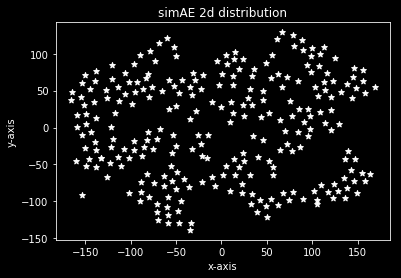

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('dark_background')

fig, ax = plt.subplots()

ax.scatter(X_trne[:,0], X_trne[:,1], c='w', marker='*')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title("simAE 2d distribution")

# plt.show()
plt.savefig('test.png', dpi=300)

In [ ]:
X_trne

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

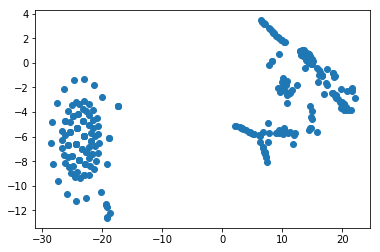

In [ ]:
plt.scatter(X_trne[:,0], X_trne[:,1])

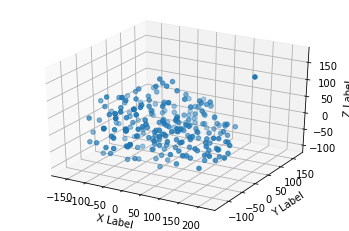

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_trne[:,0], X_trne[:,1], X_trne[:,2], marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# Clustering

## DBSCAN

Estimated number of clusters: 1
Estimated number of noise points: 125
Silhouette Coefficient: -0.021


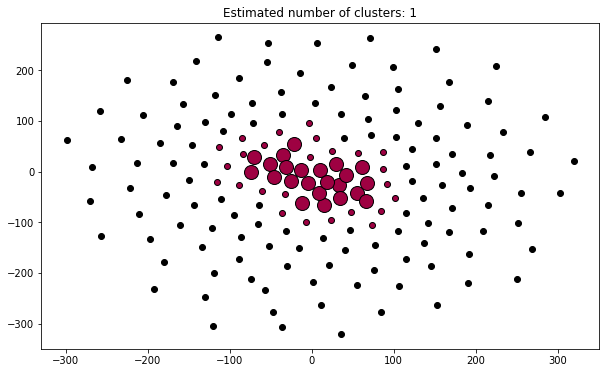

In [ ]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                             random_state=0)

# X = StandardScaler().fit_transform(X)
X = X_trne
# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=50, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels,
#                                            average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Affinity

In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

# #############################################################################
# Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
#                             random_state=0)
X = X_trne

# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-100).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels,
#                                            average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 173


ValueError: ignored

## Affinity 2

In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

# #############################################################################
# Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
#                             random_state=0)
X = X_trne

# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-200).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels,
#                                            average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 173


ValueError: ignored

Estimated number of clusters: 14
Silhouette Coefficient: 0.433


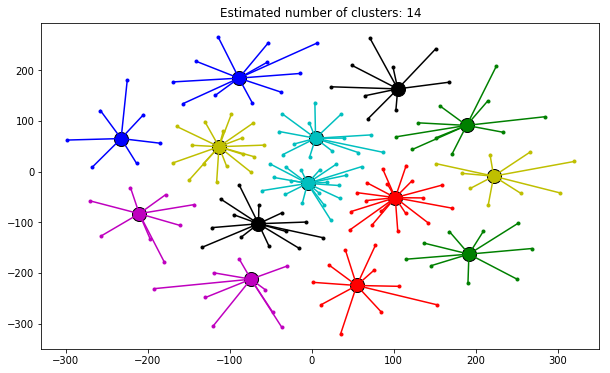

In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

# #############################################################################
# Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
#                             random_state=0)
X = X_trne

# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=None).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels,
#                                            average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


In [ ]:
cluster_centers_indices

array([  9,  12,  17,  19,  32,  35,  82,  83, 121, 125, 127, 129, 145,
       166])

In [ ]:
len(labels)


173

In [ ]:
cluster_result = pd.DataFrame({'id':list(train_index), 'group':labels})

In [ ]:
centers = list()
for i in cluster_centers_indices:
  print(cluster_result.loc[i,'id'],cluster_result.loc[i,'group'])
  centers.append(cluster_result.loc[i,'id'])
for i in cluster_centers_indices:
  print(cluster_result.loc[i,'id'],cluster_result.loc[i,'group'])

661940 0
948630 1
204530 2
362490 3
537630 4
91700 5
343780 6
730 7
958260 8
619930 9
1070040 10
663370 11
596650 12
643590 13
661940 0
948630 1
204530 2
362490 3
537630 4
91700 5
343780 6
730 7
958260 8
619930 9
1070040 10
663370 11
596650 12
643590 13


In [ ]:
edges = list()

for i in range(0,14):
  one_cluster = cluster_result[cluster_result['group']==i]
  for index, row in one_cluster.iterrows():
#     print(row['id'])
    if row['id'] not in centers:
      edges.append((centers[i],row['id']))
  

In [ ]:
edge_data = pd.DataFrame(edges, columns = ['source','target'], index=None)

In [ ]:
cluster_result.set_index('id', inplace=True)
edge_data.set_index('source', inplace=True)

In [ ]:
cluster_result.to_csv(path_or_buf=project_path+'cluster_result.csv')
edge_data.to_csv(path_or_buf=project_path+'edges_result.csv')

## OPTICS

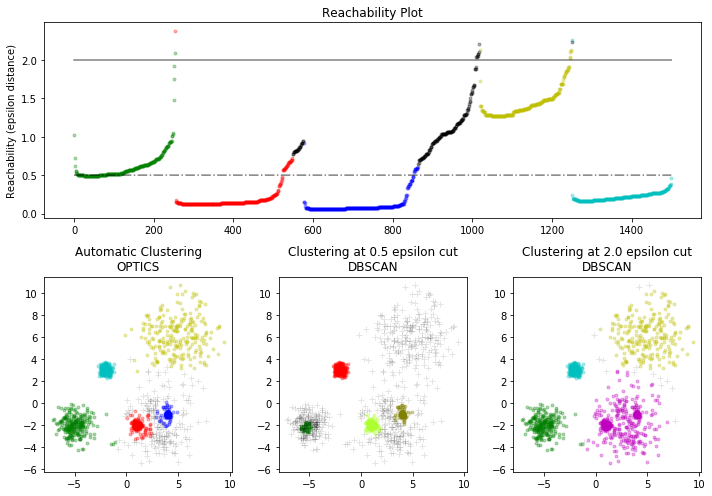

In [ ]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data

np.random.seed(0)
n_points_per_cluster = 250

C1 = [-5, -2] + .8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + .1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + .2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + .3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))

clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(X)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=2)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

# DBSCAN at 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 0.5 epsilon cut\nDBSCAN')

# DBSCAN at 2.
colors = ['g.', 'm.', 'y.', 'c.']
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at 2.0 epsilon cut\nDBSCAN')

plt.tight_layout()
plt.show()

In [ ]:
X

array([[-3.58875812, -1.67987423],
       [-4.21700961, -0.20728544],
       [-3.50595361, -2.7818223 ],
       ...,
       [ 5.64006386, 10.15835333],
       [ 3.18506804,  5.61519158],
       [ 2.57496851,  5.83880297]])

# Plot t-SNE visualization

In [ ]:
E_train.shape

(173, 6, 14, 512)

In [ ]:
vector_matrix = pd.DataFrame(E_train_flatten).set_index(pd.Series(train_index))

In [ ]:
vector_matrix.to_csv(path_or_buf=project_path+'vector_matrix.csv')

In [ ]:
vector_matrix.shape

(173, 43008)

In [ ]:
dis_matrix = pd.DataFrame(distance_matrix(vector_matrix.values, vector_matrix.values), index=vector_matrix.index, columns=vector_matrix.index)

In [ ]:
dis_matrix.head()

,105600,590950,384680,550840,4570,283040,819630,272890,1072610,661940,431730,343990,948630,365020,385760,359550,20900,204530,719720,362490,256370,663390,691630,218230,458710,298630,246420,838390,661790,70620,550,640820,537630,265300,55140,91700,555440,291480,513710,277430,...,22490,390030,228300,1049660,967050,417750,594650,296490,339610,610310,7520,603700,596650,463350,286160,877180,383120,314340,281990,636070,550650,718590,601430,334940,552990,858210,381590,462200,814380,356310,393190,416000,485510,643590,362830,630,242050,252330,32360,880470
105600,0.000000,196.239792,226.628052,254.527893,283.064270,215.919632,193.816467,443.023560,189.895630,427.937225,233.626190,357.457031,389.967682,351.465546,345.486786,264.813477,378.617981,344.571594,280.760895,279.526672,525.420166,151.594971,307.563385,258.257874,119.092308,343.407776,412.166931,330.553345,288.630188,201.270935,208.509888,438.675507,119.537743,366.660339,286.587250,290.968414,283.849304,317.910278,543.581238,340.985199,...,408.423676,525.977539,347.587097,135.393417,373.462677,297.097260,357.420502,284.018097,377.678986,584.834839,405.987946,247.834488,469.856354,321.062836,102.892143,245.419632,451.364410,376.945282,263.436737,458.960968,455.510468,288.150879,485.032043,341.123535,311.872833,294.333130,452.910797,218.246338,313.330414,433.489777,322.371490,78.958344,322.114319,180.565857,206.049744,349.096680,245.267349,316.344727,423.234924,420.686432
590950,196.239792,0.000000,30.401114,59.408485,112.910713,36.733868,36.997902,297.568848,245.884995,307.526581,85.286118,328.409790,228.051041,155.265564,197.070663,77.971336,231.865295,149.319855,197.147842,98.303345,349.636383,159.799286,151.444977,123.996658,78.690910,288.145172,240.148636,145.616333,127.008606,207.918808,61.116764,243.273087,103.422516,281.291534,204.537552,185.697433,134.577148,136.801682,355.537689,190.025131,...,325.245758,329.762115,168.124237,117.626495,179.898300,108.781898,240.925323,88.550972,215.647736,404.108093,211.183289,225.704956,276.116211,245.805237,206.322235,81.705795,352.670685,197.417877,107.359184,268.165100,260.969788,92.750420,296.297302,170.248016,321.973724,121.600479,290.452087,84.694214,172.068008,240.743149,150.395630,120.033974,211.916458,36.374950,151.154358,157.576736,72.771103,123.247093,227.006058,230.216751
384680,226.628052,30.401114,0.000000,30.927834,96.778198,34.131470,52.160969,281.442108,266.027252,295.323181,81.727798,333.223755,209.079514,124.864471,181.497116,55.957287,215.434189,119.560959,199.853653,76.359734,323.967285,181.791199,135.970825,118.694366,108.927040,289.764740,216.562500,119.657303,111.441948,224.048767,65.976738,213.290421,130.871155,277.342712,205.170151,182.353302,122.878067,114.018845,326.919189,175.737854,...,320.335175,299.363190,143.662430,142.049988,150.818253,82.405586,231.747757,58.980938,195.460983,377.037231,181.483612,236.221588,246.693192,245.428635,233.668869,73.535896,344.000763,172.300888,96.285553,239.086761,230.919571,62.741932,268.407104,150.206039,333.127655,101.901375,268.641022,89.197830,159.951904,211.747055,129.305481,150.305191,205.653030,57.507973,164.227661,128.822800,59.789551,94.868210,196.609924,201.365677
550840,254.527893,59.408485,30.927834,0.000000,74.253006,61.075218,68.018784,255.675781,295.706146,301.063782,101.767906,354.074524,181.739304,98.853958,185.162811,30.727213,217.310410,90.147102,191.871429,77.228935,310.931427,195.023056,141.287979,135.088242,135.716171,308.468964,208.207458,109.533173,117.948929,252.243942,92.179230,184.238968,152.177628,291.480621,224.018219,198.392914,133.056900,85.041245,307.668671,152.371719,...,333.220856,272.453430,135.494003,159.156647,120.502678,73.961357,241.472931,29.494827,192.730179,361.057495,151.894577,261.435059,216.714127,262.954193,253.496521,62.254135,353.065582,162.094681,108.767952,219.056931,207.431854,43.808754,237.566284,122.661415,358.230042,103.668152,262.409393,88.974144,168.193329,181.376297,127.353607,176.924225,218.642181,88.360191,167.965637

In [ ]:
X = E_train_flatten
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)

In [ ]:
# print("Visualizing t-SNE on training images...")
# outFile = os.path.join(outPath, "{}_tsne.png".format(modelName))
# plot_tsne(E_train_flatten, imgs_train, outFile)

In [ ]:
max_dis = np.max(dis_matrix.values)
np.fill_diagonal(dis_matrix.values, max_dis)
min_dis = np.min(dis_matrix.values)
np.fill_diagonal(dis_matrix.values, min_dis)

In [ ]:
dis_matrix = (dis_matrix-min_dis)/(max_dis-min_dis)

In [ ]:
dis_matrix

,105600,590950,384680,550840,4570,283040,819630,272890,1072610,661940,431730,343990,948630,365020,385760,359550,20900,204530,719720,362490,256370,663390,691630,218230,458710,298630,246420,838390,661790,70620,550,640820,537630,265300,55140,91700,555440,291480,513710,277430,...,22490,390030,228300,1049660,967050,417750,594650,296490,339610,610310,7520,603700,596650,463350,286160,877180,383120,314340,281990,636070,550650,718590,601430,334940,552990,858210,381590,462200,814380,356310,393190,416000,485510,643590,362830,630,242050,252330,32360,880470
105600,0.000000,0.299586,0.349789,0.395881,0.443025,0.332098,0.295583,0.707285,0.289105,0.682362,0.361350,0.565925,0.619634,0.556027,0.546150,0.412873,0.600884,0.544638,0.439219,0.437180,0.843408,0.225831,0.483498,0.402043,0.172135,0.542715,0.656308,0.521479,0.452220,0.307898,0.319857,0.700102,0.172871,0.581129,0.448845,0.456083,0.444322,0.500592,0.873411,0.538713,...,0.650124,0.844329,0.549619,0.199065,0.592367,0.466208,0.565865,0.444600,0.599333,0.941564,0.646100,0.384823,0.751614,0.505800,0.145371,0.380834,0.721065,0.598121,0.410599,0.733615,0.727914,0.451428,0.776685,0.538941,0.490618,0.461641,0.723619,0.335942,0.493026,0.691535,0.507962,0.105832,0.507537,0.273692,0.315793,0.552113,0.380582,0.498006,0.674593,0.670383
590950,0.299586,0.000000,0.025613,0.073534,0.161923,0.036075,0.036511,0.466987,0.381603,0.483438,0.116285,0.517938,0.352140,0.231895,0.300959,0.104201,0.358441,0.222072,0.301086,0.137791,0.553005,0.239385,0.225583,0.180237,0.105390,0.451418,0.372126,0.215954,0.185213,0.318881,0.076356,0.377288,0.146248,0.440096,0.313295,0.282170,0.197717,0.201392,0.562754,0.289319,...,0.512710,0.520172,0.253138,0.169713,0.272589,0.155102,0.373409,0.121679,0.331649,0.642995,0.324274,0.348264,0.431546,0.381471,0.316243,0.110371,0.558018,0.301533,0.152751,0.418410,0.406523,0.128617,0.464886,0.256647,0.507305,0.176279,0.455230,0.115308,0.259653,0.373108,0.223850,0.173691,0.325485,0.035482,0.225103,0.235713,0.095610,0.178999,0.350414,0.355718
384680,0.349789,0.025613,0.000000,0.026483,0.135271,0.031775,0.061561,0.440345,0.414879,0.463277,0.110407,0.525891,0.320798,0.181671,0.275231,0.067833,0.331296,0.172909,0.305557,0.101539,0.510598,0.275717,0.200019,0.171477,0.155341,0.454094,0.333160,0.173068,0.159496,0.345528,0.084385,0.327755,0.191594,0.433572,0.314340,0.276645,0.178389,0.163753,0.515475,0.265716,...,0.504598,0.469951,0.212726,0.210062,0.224548,0.111527,0.358247,0.072828,0.298300,0.598273,0.275208,0.365638,0.382938,0.380849,0.361421,0.096873,0.543695,0.260038,0.134457,0.370372,0.356879,0.079041,0.418810,0.223536,0.525732,0.143735,0.419197,0.122748,0.239637,0.325205,0.189008,0.223700,0.315137,0.070395,0.246701,0.188210,0.074164,0.132116,0.300198,0.308055
550840,0.395881,0.073534,0.026483,0.000000,0.098058,0.076288,0.087759,0.397777,0.463910,0.472761,0.143514,0.560337,0.275631,0.138700,0.281287,0.026151,0.334396,0.124316,0.292370,0.102975,0.489062,0.297576,0.208803,0.198561,0.199598,0.484994,0.319357,0.156343,0.170246,0.392108,0.127673,0.279760,0.226793,0.456929,0.345478,0.303143,0.195205,0.115881,0.483672,0.227114,...,0.525886,0.425495,0.199231,0.238323,0.174465,0.097576,0.374314,0.024116,0.293788,0.571873,0.226326,0.407292,0.333411,0.409802,0.394177,0.078235,0.558670,0.243177,0.155079,0.337281,0.318076,0.047763,0.367860,0.178031,0.567202,0.146653,0.408902,0.122378,0.253252,0.275031,0.185783,0.267676,0.336596,0.121364,0.252876,0.159405,0.098537,0.081271,0.255937,0.276599
4570,0.443025,0.161923,0.135271,0.098058,0.000000,0.191566,0.129718,0.281299,0.568137,0.585781,0.265438,0.682593,0.166048,0.176597,0.393945,0.047316,0.443374,0.135941,0.192678,0.219282,0.557729,0.275409,0.325056,0.321209,0.253365,0.607661,0.407605,0.250907,0.288579,0.503463,0.244224,0.267469,0.249327,0.578353,0.468108,0.425601,0.315710,0.039389,0.527577,0.105884,...,0.646351,0.425156,0.294410,0.240266,0.157166,0.202695,0.492751,0.095930,0.395659,0.627599,0.212897,0.525505,0.303502,0.532427,0.394436,0.037704,0.675424,0.3

In [ ]:
dis_matrix.to_csv(path_or_buf=project_path+'final_distance_matrix.csv')

# Community Detection

In [ ]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import PIL.ImageOps    
from PIL import Image
import numpy as np
import itertools
import math
import sys
import os

In [ ]:
savedir = project_path
# Creates a NetworkX graph object
def make_graph(sim, labels=None):
    G = nx.Graph()
    for i in range(sim.shape[0]):
        for j in range(sim.shape[1]):
            if i != j and sim.iloc[i,j] != 0:
                if labels == None:
                    G.add_edge(i, j, weight=sim.iloc[i,j])
                else:
                    G.add_edge(labels[i], labels[j], weight=sim.iloc[i,j])
    return G

# Generate edges for Gephi or pals  
def export_edge_list(sim, labels=None, filename="edges.csv", delim=",", header=True):
    f = open(savedir + filename, 'w')
    if header:
        f.write("Source,Target\n")
    loc = np.where(sim > 0)
    for (i, j) in [(i, j) for (i, j) in zip(loc[0], loc[1]) if i < j]:
        if labels == None:
            f.write(str(i) + delim + str(j) + "\n")
        else:
            f.write("\"" + labels[i] + "\"" + delim + "\"" + labels[j] + "\"\n")                          
    f.close()

## Build Graph

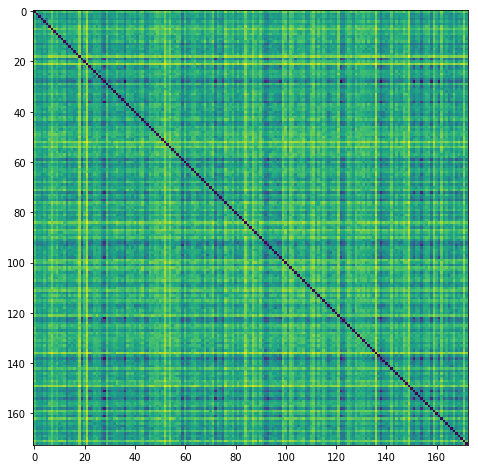

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(dis_matrix)
plt.show()

In [ ]:
dm = dis_matrix.copy()
dm[dm > 0.4] = 0

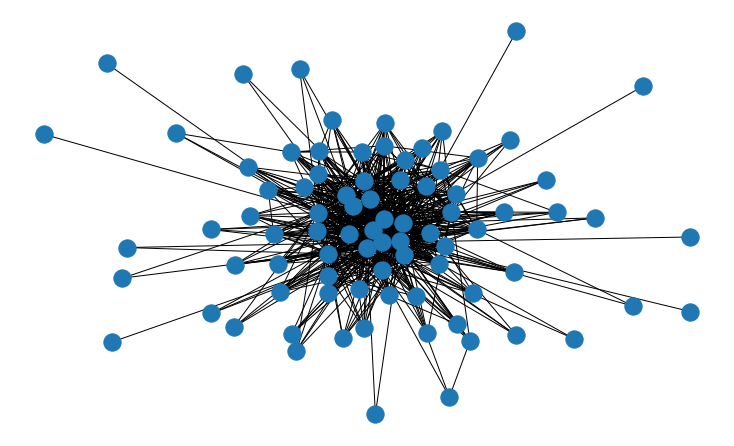

In [ ]:
G = make_graph(dm, labels=train_index)
plt.rcParams["figure.figsize"]=(10,6)
nx.draw(G, with_labels=False)

## Color

In [ ]:
class Config():
    colors = ['aquamarine', 'bisque', 'blanchedalmond', 'blueviolet', 'brown',
              'burlywood', 'cadetblue', 'chartreuse','chocolate', 'coral',
              'cornflowerblue', 'cornsilk', 'crimson', 'darkblue', 'darkcyan',
              'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki',
              'darkmagenta', 'darkolivegreen', 'darkorange', 'darkslateblue',
              'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
              'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet',
              'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue',
              'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
              'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow',
              'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory']

Possible clusters 1 : ({'230840', '856110', '463000', '510700', '865240', '385950', '681750', '774331', '585290', '477910', '403780', '692830', '332880', '433170', '470470', '391100', '219070', '940130', '528860', '574410', '530520', '295490', '711930', '1061270', '522570', '742480', '498620', '702180', '912790', '571520', '341460', '584760', '561600', '1097620', '1024780', '705300', '569430', '1023570', '576500', '729650', '790120', '356040', '830500', '485490', '601010', '1064930', '577580', '670430', '1046530', '546980', '995170', '800520', '1026380', '396700', '482440', '330840', '693280', '864500', '722220', '817460', '777870', '347080', '828170', '253290', '588540', '525240', '542850', '786950', '864010', '864880', '921920', '862570', '445750', '457420', '277390', '375290', '822650', '1014100', '904800', '648070', '355410', '266430', '499330', '344910', '963210', '443070', '755230', '440450', '396310', '346800', '976360', '623920', '1061250', '509170', '598590', '26800', '349100'

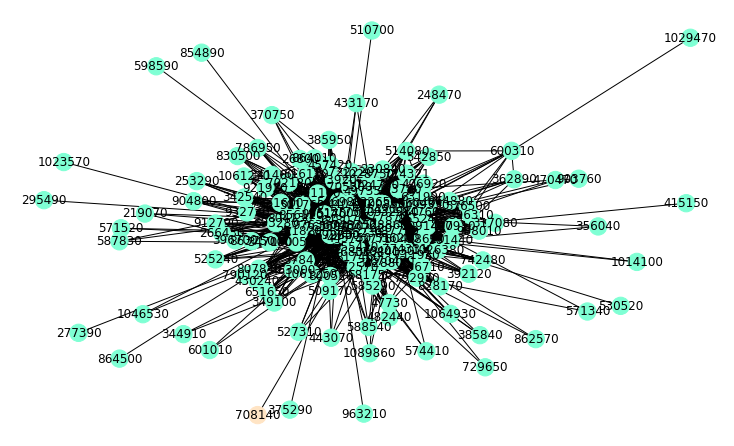

Possible clusters 2 : ({'230840', '856110', '463000', '510700', '865240', '385950', '681750', '774331', '585290', '477910', '403780', '692830', '332880', '433170', '470470', '391100', '219070', '940130', '528860', '574410', '530520', '295490', '711930', '1061270', '522570', '742480', '498620', '702180', '912790', '571520', '341460', '584760', '561600', '1097620', '1024780', '705300', '569430', '576500', '729650', '790120', '356040', '830500', '485490', '601010', '1064930', '577580', '670430', '1046530', '546980', '995170', '800520', '1026380', '396700', '482440', '330840', '693280', '864500', '722220', '817460', '777870', '347080', '828170', '253290', '588540', '525240', '542850', '786950', '864010', '864880', '921920', '862570', '445750', '457420', '277390', '375290', '822650', '1014100', '904800', '648070', '355410', '266430', '499330', '344910', '963210', '443070', '755230', '440450', '396310', '346800', '976360', '623920', '1061250', '509170', '598590', '26800', '349100', '651650',

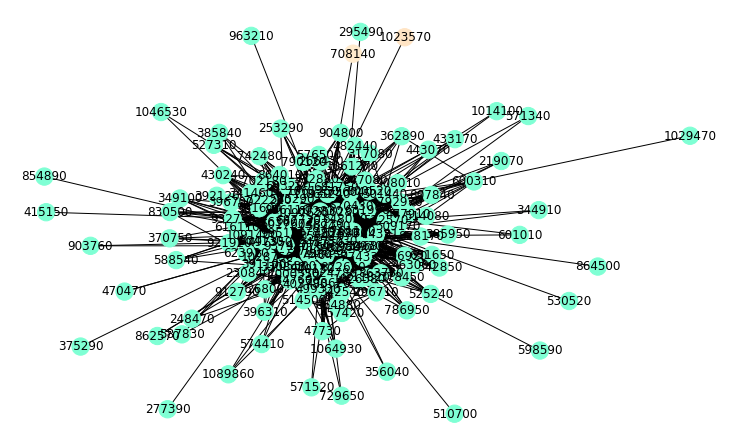

Possible clusters 3 : ({'230840', '856110', '463000', '510700', '865240', '385950', '681750', '774331', '585290', '477910', '403780', '692830', '332880', '433170', '470470', '391100', '219070', '940130', '528860', '574410', '530520', '295490', '711930', '1061270', '522570', '742480', '498620', '702180', '912790', '571520', '341460', '584760', '561600', '1097620', '1024780', '705300', '569430', '576500', '729650', '790120', '356040', '830500', '485490', '601010', '1064930', '577580', '670430', '1046530', '546980', '995170', '800520', '1026380', '396700', '482440', '330840', '693280', '864500', '722220', '817460', '777870', '347080', '828170', '253290', '588540', '525240', '542850', '786950', '864010', '864880', '921920', '862570', '445750', '457420', '277390', '375290', '822650', '1014100', '904800', '648070', '355410', '266430', '499330', '344910', '443070', '755230', '440450', '396310', '346800', '976360', '623920', '1061250', '509170', '598590', '26800', '349100', '651650', '854890',

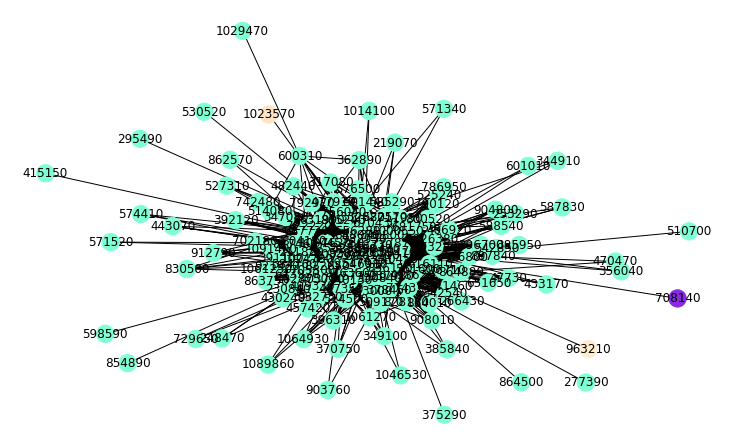

Possible clusters 4 : ({'230840', '856110', '463000', '510700', '865240', '385950', '681750', '774331', '585290', '477910', '403780', '692830', '332880', '433170', '470470', '391100', '219070', '940130', '528860', '574410', '530520', '295490', '711930', '1061270', '522570', '742480', '498620', '702180', '912790', '571520', '341460', '584760', '561600', '1097620', '1024780', '705300', '569430', '576500', '729650', '790120', '356040', '830500', '485490', '601010', '1064930', '577580', '670430', '1046530', '546980', '995170', '800520', '1026380', '396700', '482440', '330840', '693280', '864500', '722220', '817460', '777870', '347080', '828170', '253290', '588540', '525240', '542850', '786950', '864010', '864880', '921920', '862570', '445750', '457420', '277390', '375290', '822650', '1014100', '904800', '648070', '355410', '266430', '499330', '344910', '443070', '755230', '440450', '396310', '346800', '976360', '623920', '1061250', '509170', '26800', '349100', '651650', '854890', '587830',

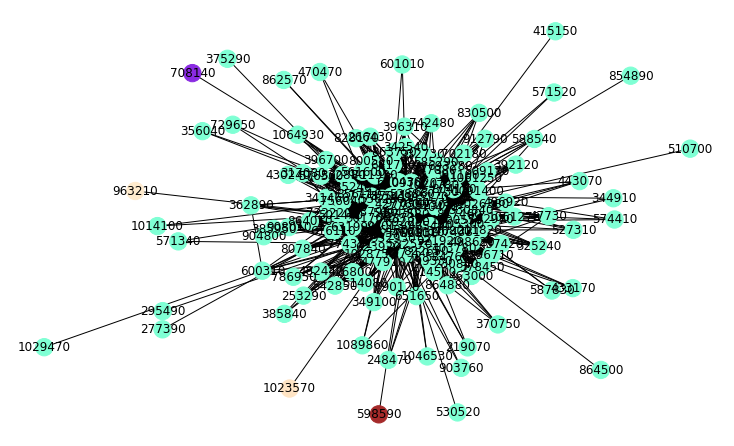

Possible clusters 5 : ({'230840', '856110', '463000', '510700', '865240', '385950', '681750', '774331', '585290', '477910', '403780', '692830', '332880', '433170', '470470', '391100', '219070', '940130', '528860', '574410', '530520', '295490', '711930', '1061270', '522570', '742480', '498620', '702180', '912790', '571520', '341460', '584760', '561600', '1097620', '1024780', '705300', '569430', '576500', '729650', '790120', '356040', '830500', '485490', '601010', '1064930', '577580', '670430', '1046530', '546980', '995170', '800520', '1026380', '396700', '482440', '330840', '693280', '722220', '817460', '777870', '347080', '828170', '253290', '588540', '525240', '542850', '786950', '864010', '864880', '921920', '862570', '445750', '457420', '277390', '375290', '822650', '1014100', '904800', '648070', '355410', '266430', '499330', '344910', '443070', '755230', '440450', '396310', '346800', '976360', '623920', '1061250', '509170', '26800', '349100', '651650', '854890', '587830', '600310',

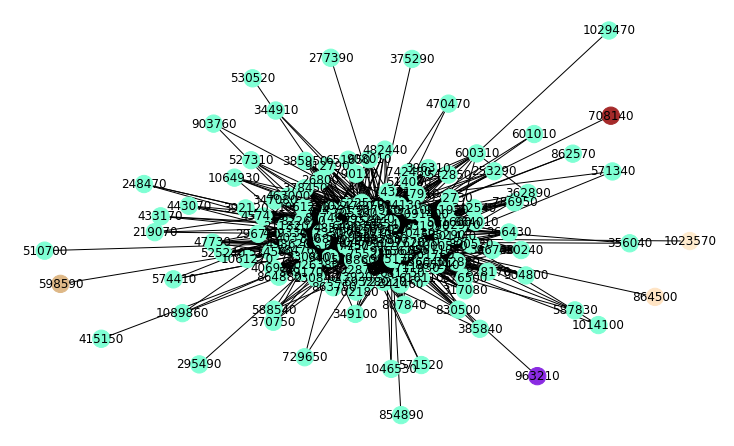

Possible clusters 6 : ({'230840', '856110', '463000', '510700', '865240', '385950', '681750', '774331', '585290', '477910', '403780', '692830', '332880', '433170', '470470', '391100', '219070', '940130', '528860', '574410', '530520', '295490', '711930', '1061270', '522570', '742480', '498620', '702180', '912790', '571520', '341460', '584760', '561600', '1097620', '1024780', '705300', '569430', '576500', '729650', '790120', '356040', '830500', '485490', '601010', '1064930', '577580', '670430', '1046530', '546980', '995170', '800520', '1026380', '396700', '482440', '330840', '693280', '722220', '817460', '777870', '347080', '828170', '253290', '588540', '525240', '542850', '786950', '864010', '864880', '921920', '862570', '445750', '457420', '375290', '822650', '1014100', '904800', '648070', '355410', '266430', '499330', '344910', '443070', '755230', '440450', '396310', '346800', '976360', '623920', '1061250', '509170', '26800', '349100', '651650', '854890', '587830', '600310', '378450',

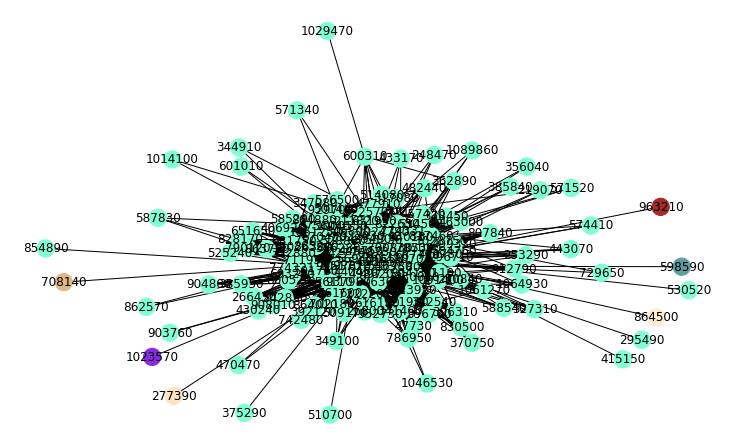

Possible clusters 7 : ({'230840', '856110', '463000', '510700', '865240', '385950', '681750', '774331', '585290', '477910', '403780', '692830', '332880', '433170', '470470', '391100', '219070', '940130', '528860', '574410', '530520', '295490', '711930', '1061270', '522570', '742480', '498620', '702180', '912790', '571520', '341460', '584760', '561600', '1097620', '1024780', '705300', '569430', '576500', '729650', '790120', '356040', '830500', '485490', '601010', '1064930', '577580', '670430', '1046530', '546980', '995170', '800520', '1026380', '396700', '482440', '330840', '693280', '722220', '817460', '777870', '347080', '828170', '253290', '588540', '525240', '542850', '786950', '864010', '864880', '921920', '862570', '445750', '457420', '822650', '1014100', '904800', '648070', '355410', '266430', '499330', '344910', '443070', '755230', '440450', '396310', '346800', '976360', '623920', '1061250', '509170', '26800', '349100', '651650', '854890', '587830', '600310', '378450', '1091400'

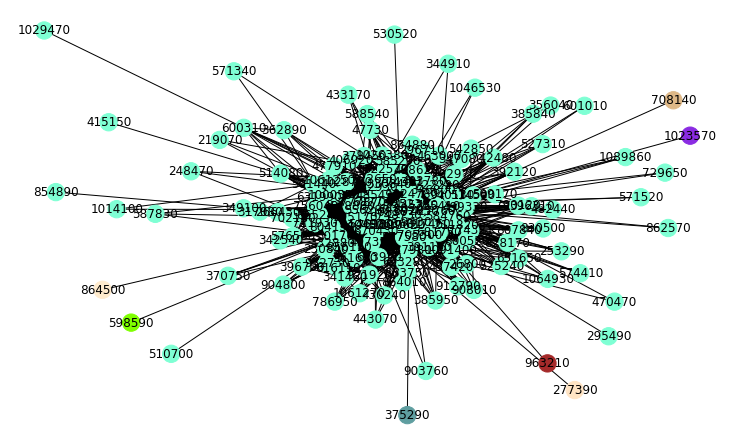

Possible clusters 8 : ({'230840', '856110', '463000', '510700', '865240', '385950', '681750', '774331', '585290', '477910', '403780', '692830', '332880', '433170', '470470', '391100', '219070', '940130', '528860', '574410', '530520', '295490', '711930', '1061270', '522570', '742480', '498620', '702180', '912790', '571520', '341460', '584760', '561600', '1097620', '1024780', '705300', '569430', '576500', '729650', '790120', '356040', '830500', '485490', '601010', '1064930', '577580', '670430', '1046530', '546980', '995170', '800520', '1026380', '396700', '482440', '330840', '693280', '722220', '817460', '777870', '347080', '828170', '253290', '588540', '525240', '542850', '786950', '864010', '864880', '921920', '862570', '445750', '457420', '822650', '1014100', '904800', '648070', '355410', '266430', '499330', '344910', '443070', '755230', '440450', '396310', '346800', '976360', '623920', '1061250', '509170', '26800', '349100', '651650', '587830', '600310', '378450', '1091400', '792970'

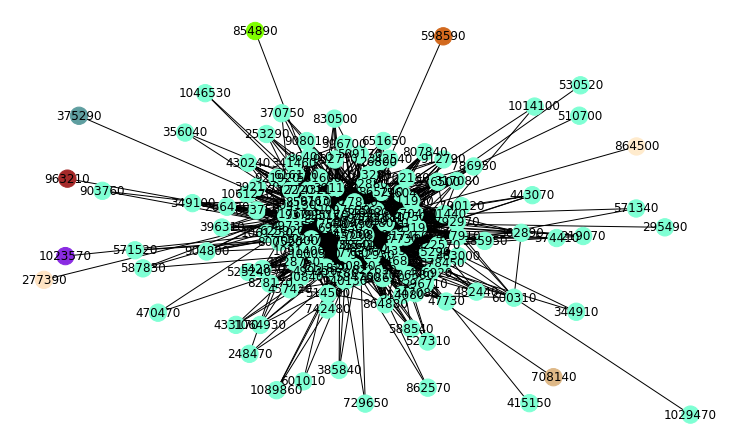

Possible clusters 9 : ({'230840', '856110', '463000', '510700', '865240', '385950', '681750', '774331', '585290', '477910', '403780', '692830', '332880', '433170', '470470', '391100', '219070', '940130', '528860', '574410', '295490', '711930', '1061270', '522570', '742480', '498620', '702180', '912790', '571520', '341460', '584760', '561600', '1097620', '1024780', '705300', '569430', '576500', '729650', '790120', '356040', '830500', '485490', '601010', '1064930', '577580', '670430', '1046530', '546980', '995170', '800520', '1026380', '396700', '482440', '330840', '693280', '722220', '817460', '777870', '347080', '828170', '253290', '588540', '525240', '542850', '786950', '864010', '864880', '921920', '862570', '445750', '457420', '822650', '1014100', '904800', '648070', '355410', '266430', '499330', '344910', '443070', '755230', '440450', '396310', '346800', '976360', '623920', '1061250', '509170', '26800', '349100', '651650', '587830', '600310', '378450', '1091400', '792970', '1089860

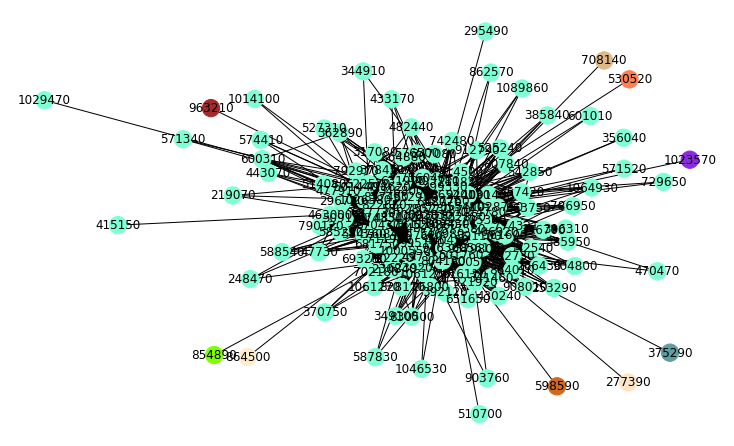

Possible clusters 10 : ({'230840', '856110', '463000', '865240', '385950', '681750', '774331', '585290', '477910', '403780', '692830', '332880', '433170', '470470', '391100', '219070', '940130', '528860', '574410', '295490', '711930', '1061270', '522570', '742480', '498620', '702180', '912790', '571520', '341460', '584760', '561600', '1097620', '1024780', '705300', '569430', '576500', '729650', '790120', '356040', '830500', '485490', '601010', '1064930', '577580', '670430', '1046530', '546980', '995170', '800520', '1026380', '396700', '482440', '330840', '693280', '722220', '817460', '777870', '347080', '828170', '253290', '588540', '525240', '542850', '786950', '864010', '864880', '921920', '862570', '445750', '457420', '822650', '1014100', '904800', '648070', '355410', '266430', '499330', '344910', '443070', '755230', '440450', '396310', '346800', '976360', '623920', '1061250', '509170', '26800', '349100', '651650', '587830', '600310', '378450', '1091400', '792970', '1089860', '57134

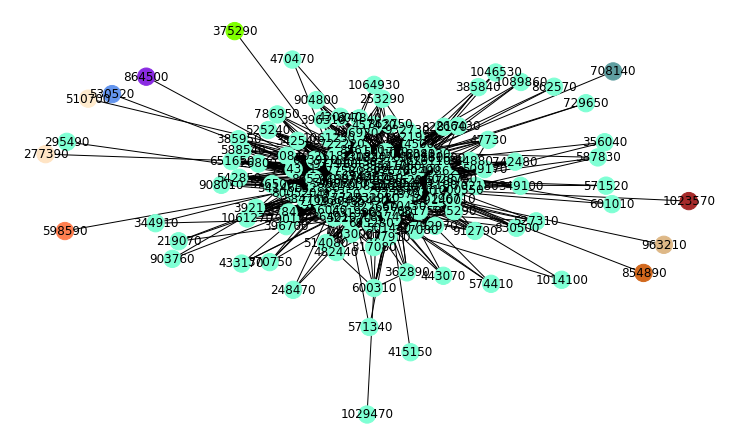

In [ ]:
from networkx.algorithms.community.centrality import girvan_newman

comp = girvan_newman(G)

max_shown = 10
shown_count = 1
possibilities = []
for communities in itertools.islice(comp, max_shown):
    print("Possible clusters", shown_count, ": ", end='')
    print(communities)
    possibilities.append(communities)
    color_map = ["" for x in range(len(G))]
    color = 0
    for c in communities:
        indices = [i for i, x in enumerate(G.nodes) if x in c]
        for i in indices:
            color_map[i] = Config.colors[color]
        color += 1
    shown_count += 1
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()



In [ ]:
export_edge_list(dm, labels=train_index, filename='new-game-edges.csv')

# Save

In [ ]:
!zip -r output.zip output

  adding: output/ (stored 0%)
  adding: output/vgg19/ (stored 0%)
  adding: output/vgg19/vgg19_retrieval_8.png (deflated 2%)
  adding: output/vgg19/vgg19_retrieval_6.png (deflated 2%)
  adding: output/vgg19/vgg19_retrieval_4.png (deflated 2%)
  adding: output/vgg19/vgg19_retrieval_2.png (deflated 1%)
  adding: output/vgg19/vgg19_retrieval_1.png (deflated 2%)
  adding: output/vgg19/vgg19_retrieval_0.png (deflated 2%)
  adding: output/vgg19/vgg19_tsne.png (deflated 1%)
  adding: output/vgg19/vgg19_retrieval_5.png (deflated 2%)
  adding: output/vgg19/vgg19_retrieval_3.png (deflated 2%)
  adding: output/vgg19/vgg19_retrieval_7.png (deflated 3%)
  adding: output/vgg19/vgg19_retrieval_9.png (deflated 2%)


In [ ]:
!mv output.zip /content/drive/My\ Drive/CD-on-Steam-Games/output.zip

In [ ]:
!unzip /content/drive/My\ Drive/CD-on-Steam-Games/output.zip -d /content/drive/My\ Drive/CD-on-Steam-Games/

Archive:  /content/drive/My Drive/CD-on-Steam-Games/output.zip
replace /content/drive/My Drive/CD-on-Steam-Games/output/vgg19/vgg19_retrieval_8.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/My Drive/CD-on-Steam-Games/output/vgg19/vgg19_retrieval_8.png  
  inflating: /content/drive/My Drive/CD-on-Steam-Games/output/vgg19/vgg19_retrieval_6.png  
  inflating: /content/drive/My Drive/CD-on-Steam-Games/output/vgg19/vgg19_retrieval_4.png  
  inflating: /content/drive/My Drive/CD-on-Steam-Games/output/vgg19/vgg19_retrieval_2.png  
  inflating: /content/drive/My Drive/CD-on-Steam-Games/output/vgg19/vgg19_retrieval_1.png  
  inflating: /content/drive/My Drive/CD-on-Steam-Games/output/vgg19/vgg19_retrieval_0.png  
  inflating: /content/drive/My Drive/CD-on-Steam-Games/output/vgg19/vgg19_tsne.png  
  inflating: /content/drive/My Drive/CD-on-Steam-Games/output/vgg19/vgg19_retrieval_5.png  
  inflating: /content/drive/My Drive/CD-on-Steam-Games/output/vgg19/vgg19_retrieva